# VAR Models

In this notebook I will carry forward the portfolio analysis performed in Portfolio_analysis notebook.
We concluded using various ratios that the portfolio is going to perform worse than the risk free rate.
In this notbook I will analyze Value At Risk(VAR) performance and try to analyze the risk associated with
the tech dominated portfolio we created. 

The concept of Value at Risk (VaR) is one of the most interesting in
finance because it analyzes the maximum loss that a portfolio can incure be subjected to. It is another measure of risk that is different from the ratios (Sharpe, Traynor, Information and Jensen) calculated in the earlier notebook. It gives the worst loss on a certain time horizon based on the confidence level assigned to the model.



### 

# Historical VaR

The confidence level assined to the model is 95% or 99%. I by buidling the portfolio that I did in earlier notebook. Assign them weights based on the market capital of each company.


In [47]:
# Import libraries

import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 


# Get stock data

# List of stock symbols
tech_stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META']

# Set the date range for the historical data
start_date = '2022-08-01'
end_date = '2023-08-01'

# Download historical stock data for each stock

stocks = yf.download(tech_stocks, start_date, end_date)['Close']


# get the weight of each stock

totalmp = 0
mcap=[]
for stock in tech_stocks:
    # Create a Ticker object
    # Create a Ticker object
    ticker = yf.Ticker(stock)

    # Fetch company information
    company_info = ticker.info

    # Get the market capitalization
    market_cap = company_info.get('marketCap', None)
    mcap.append(market_cap)
    totalmp += market_cap

weights = [mc/totalmp for mc in mcap]




[*********************100%%**********************]  5 of 5 completed


In [48]:
# calculate the returns

stocks_return = stocks.pct_change()

# calculate wieghted returns
weighted_returns_portfolio = stocks_return.mul(weights,axis = 1)

stocks_return['Portfolio'] = weighted_returns_portfolio.sum(axis=1).dropna()


<Axes: xlabel='Date', ylabel='Returns'>

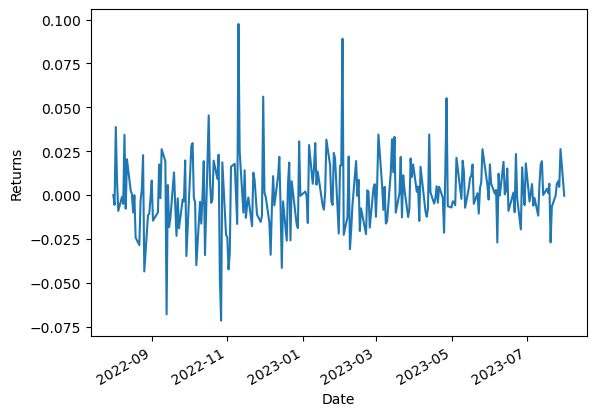

In [49]:
stocks_return['Portfolio'].plot(ylabel='Returns')

In [50]:
# calculate Historical VaR(95) and VAR99

var95 = np.percentile(stocks_return['Portfolio'], 5)* 100
var99 = np.percentile(stocks_return['Portfolio'], 1)* 100

print(f"VAR95:{var95} and VAR99:{var99}")

VAR95:-2.7777987749324184 and VAR99:-4.5593452516299315


Based on the historical data of returns at a 95% and 99% confidence interval, the worst loss is 3% and 4.9% respectively.

## VAR for 10 days

We can also get the effect on the investment amount in terms of absolute money.
Assumming the total value of portfolio at the time of investment is 1 million dollars. 

$VaR = position * (\mu − \sigma * \alpha)$

- $\mu$ = mean of the returns of the portfolio
- $\sigma$ = standard deviation of the returns of the portfolio
- $\alpha$ = Probability density function of the 1%


In [51]:
import scipy.stats as stats

# get mean of returns
mu = stocks_return['Portfolio'].mean()

# get standard deviation of returns

sigma = stocks_return['Portfolio'].std()

# if the confidence level is 99%, calculate alpha
confidence = 0.99

alpha = stats.norm.ppf(1 -confidence)

# given initial investment of $1M 
position = 1e6

# calculate VAR
var = position*(mu-sigma*alpha)

print(f"VAR: $ {var}")

VAR: $ 47586.90126458527


If the initial investment was of 1 million dollars. The worst loss with a 99% confidence interval can be of $47586.90 in the coming day. 

What is the expected loss in the nect 10 days? 

$VaR(days) = position ∗ (\mu ∗ days − \sigma ∗ \alpha ∗\sqrt{days}$


In [53]:
# VAR for 10 days

days=10
var_10_days = position *(mu*days-sigma*alpha*np.sqrt(days))

print(f"VAR for 10 days with 99% confidence: $ {var_10_days}")

VAR for 10 days with 99% confidence: $ 158585.24446601924


In [54]:
(position - var_10_days)/position

0.8414147555339808

The value of the 1 million investment in the next 10 could result at worst in value that is 84.14% of the initial investment with 99% confidence.

## Historical Drawdown

The difference of historical drawdown with VAR is that is uses negative returns of portfolio.
It analyzes the decline in the specific period that the portfolio is being analyzed and
based on the cumulative growth analyzes the peak and therefore the fall
or drawdown of the portfolio.



In [55]:
# get cumulative returns

cummulative_returns = (1 + stocks_return['Portfolio']).cumprod() -1 

<Axes: xlabel='Date', ylabel='Cumulative Returns'>

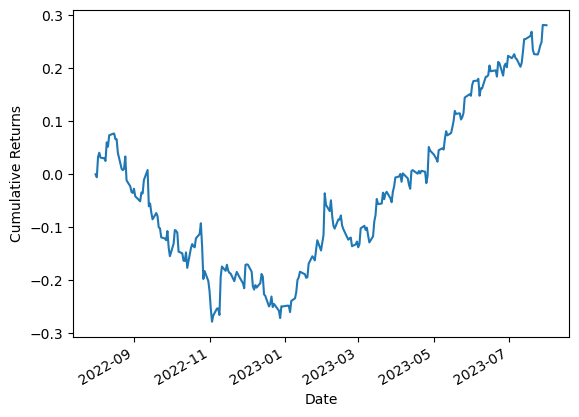

In [56]:
# plot the cummulative returns

cummulative_returns.plot(ylabel='Cumulative Returns')

To calculate running maximum we take the maximum of the cummulative returns and accumulate in order to get a constant retrn. This is required because the drawdown formular divides the cum. ret. into running maximums. 

To accumulate the maximum values of an array in NumPy, you can use the numpy.maximum.accumulate() function. This function returns an array of the same shape as the input array, where each element is the maximum value encountered up to that position in the input array.


In [58]:
# get the runnning maxima

running_maximum = np.maximum.accumulate(cummulative_returns)
running_maximum = running_maximum[running_maximum < 1]


In [60]:
portfolio_drawdown = (cummulative_returns)/running_maximum - 1

<Axes: xlabel='Date', ylabel='Drawdown'>

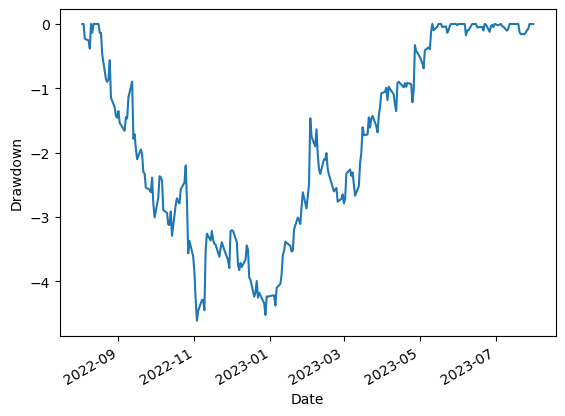

In [61]:
portfolio_drawdown.plot(ylabel='Drawdown')

The plot shows that the the returns are negative and it demonstrates that the worst loss is between Aug 2022 and
Aug 2023. The worst loss is more than 4.5%. Therefore this not a very stable portfolio.  

## Analysis using ffn library



In [63]:
import ffn 

stocks = ffn.get(tech_stocks, start=start_date, end=end_date)
# returns
stocks_return = stocks.pct_change()
#weights

# get the weight of each stock

totalmp = 0
mcap=[]
for stock in tech_stocks:
    # Create a Ticker object
    # Create a Ticker object
    ticker = yf.Ticker(stock)

    # Fetch company information
    company_info = ticker.info

    # Get the market capitalization
    market_cap = company_info.get('marketCap', None)
    mcap.append(market_cap)
    totalmp += market_cap

weights = [mc/totalmp for mc in mcap]

# calculate wieghted returns
weighted_returns_portfolio = stocks_return.mul(weights,axis = 1)

stocks_return['Portfolio'] = weighted_returns_portfolio.sum(axis=1).dropna()

# calculate the performance of the portfolio

performance = stocks_return.calc_stats()

/home/ankitsingh/miniconda3/envs/DS/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ankitsingh/miniconda3/envs/DS/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ankitsingh/miniconda3/envs/DS/lib/python3.11/site-packages/ffn/core.py:1379: RuntimeWarning: invalid value encountered in scalar power
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1
/home/ankitsingh/miniconda3/envs/DS/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ankitsingh/miniconda3/envs/DS/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, *

In [64]:
# display the performance

performance.display()

Stat                 aapl        msft        amzn        googl       meta        Portfolio
-------------------  ----------  ----------  ----------  ----------  ----------  -----------
Start                2022-08-02  2022-08-02  2022-08-02  2022-08-02  2022-08-02  2022-08-02
End                  2023-07-31  2023-07-31  2023-07-31  2023-07-31  2023-07-31  2023-07-31
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         -134.09%    -36.90%     -222.39%    -55.08%     -1400.18%   -89.30%
Daily Sharpe         -           -1.27       -2.69       -           -           0.39
Daily Sortino        inf         -2.32       -2.99       -           -           1.41
CAGR                 -           -37.08%     -           -55.30%     -           -89.44%
Max Drawdown         -252.38%    -297.51%    -276.65%    -358.83%    -508.93%    -279.89%
Calmar Ratio         -           -0.12       -           -0.15       -           -0.32

MTD             

These line tell us about the performance 

Total Return         -134.09%    -36.90%     -222.39%    -55.08%     -1400.18%   -89.30%
Avg. Drawdown        -189.93%    -225.01%    -215.68%    -231.89%    -216.22%    -219.20%
Avg. Drawdown Days   89.00       58.83       89.50       59.00       59.33       119.67
Best Month           265.38%     239.56%     152.29%     1231.51%    1852.55%    831.86%
Worst Month          -8293.11%   -605.80%    -1299.98%   -888.02%    -229.64%    -1468.82%

It tells us that during the period of Aug 2022 and Aug 2023, this portfolio would give a return of -89%, a drawdown of 219% with average of 119.67 days. The best month created 831% but the worst month supercedes that with loss of 1468%. 

This information can be used for corretions and backtesting to optimise the performance. 

### Fund performances

Lets check the performance of Morgan Stanley Institutional Fund, Inc.
Asia Opportunity Portfolio Class A (MSAUX) 

In [2]:

import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import ffn

start_date = '2022-08-01'
end_date = '2023-08-01'

funds = ffn.get('MSAUX:Close,MIOPX:Close,MGGPX:Close,MFAPX:Close',start=start_date,end=end_date)

funds.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,msauxclose,miopxclose,mggpxclose,mfapxclose
Date,,,,
2023-07-25,18.950001,23.260000,26.34,22.340000
2023-07-26,19.129999,23.309999,26.32,22.240000
2023-07-27,18.980000,23.240000,26.18,22.290001
2023-07-28,19.520000,23.740000,26.77,22.510000
2023-07-31,19.809999,23.900000,27.09,22.480000


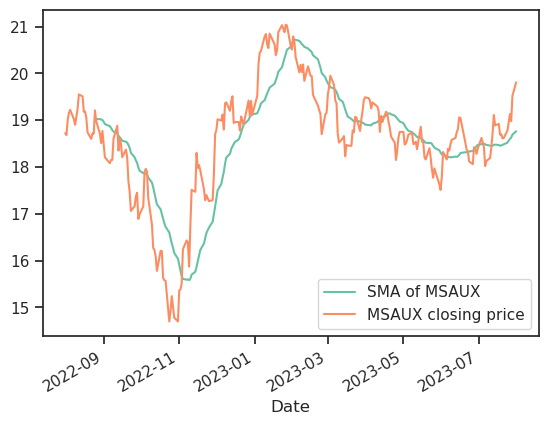

In [6]:
import talib 
# calculate simple moving average for MSAUX 
# window of 20 days

funds['MA-msaux'] = talib.SMA(funds['msauxclose'], timeperiod=20)

# plot 

funds['MA-msaux'].plot(label='SMA of MSAUX')
funds['msauxclose'].plot(label='MSAUX closing price')
plt.legend()

### EMA

EMA: exponential moving average, gives more weightage to recent values

$EMA(t) = (P(t) * \alpha) + (EMA(y) * (1 - \alpha))$

- EMA(t) is the EMA value at time "t."

- P(t) is the price or value at time "t."

- EMA(y) is the EMA value from the previous time period (y).

- $\alpha$ (alpha) is the smoothing factor, which is calculated based on the number of periods you want to consider. The formula 

$α = 2 / (N + 1)$

Where "N" is the number of periods.



<Axes: xlabel='Date', ylabel='[MSAUX, EMA]'>

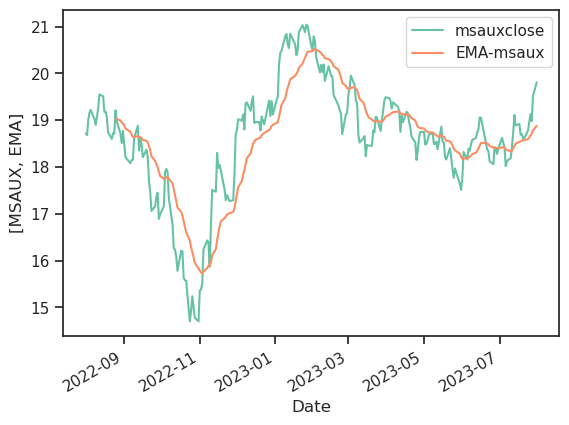

In [8]:
# calculate EMA for MSAUX

funds['EMA-msaux'] = talib.EMA(funds['msauxclose'], timeperiod=20)

funds[['msauxclose','EMA-msaux']].plot(ylabel=['MSAUX','EMA'])

### Bollinger Bands

It used in financial markets and other fields to assess price volatility, identify potential trend reversals, and determine overbought or oversold conditions in a market.

- Middle Band is the EMA described above
- Upper Bollinger Band = Middle Band + (2 * Standard Deviation of Price Data)
- Lower Bollinger Band = Middle Band - (2 * Standard Deviation of Price Data)

When the price touches or crosses the upper band, it may indicate that the asset is overbought and potentially due for a reversal. Conversely, when the price touches or crosses the lower band, it may suggest that the asset is oversold and could be due for a bounce.

When prices move outside the bands and then re-enter, it could signal a reversal in the current trend. 

<Axes: xlabel='Date', ylabel='[MSAUX, up_band, mid_band, low_band]'>

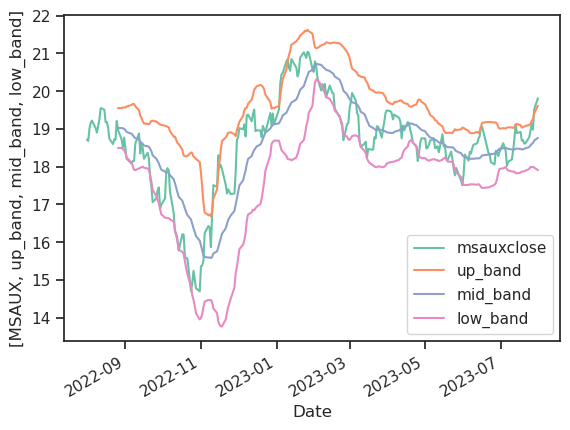

In [9]:
# calculate the Bollinger Bands

funds['up_band'],funds['mid_band'],funds['low_band'] = talib.BBANDS(funds['msauxclose'], timeperiod=20)

funds[['msauxclose','up_band','mid_band','low_band']].plot(ylabel=['MSAUX','up_band','mid_band','low_band'])


### Relative Strength Index 

It is a popular momentum oscillator used in technical analysis to assess the strength and speed of a price movement. It is a valuable tool for identifying overbought and oversold conditions in a market, as well as potential trend reversals. 

$RSI = 100 - [100 / (1 + RS)]$

where RS (Relative Strength) is the ratio of the average of "n" days' up-closes to the average of "n" days' down-closes. 

$RS = \frac{Average \ Gain \ over \ "n" days}{Average \ Loss \ over \ "n" \ days}$

"n" typically represents a user-defined number of periods, often 14.

- Oscillator Values: The RSI value ranges from 0 to 100. It is plotted on a vertical scale on a price chart. Generally, RSI values above 70 are considered overbought, suggesting that the asset may be due for a price correction or reversal. Conversely, RSI values below 30 are considered oversold, indicating that the asset may be due for a bounce or recovery.
- Divergence: RSI divergence occurs when the RSI indicator disagrees with the price movement. For example, if the price is making higher highs, but the RSI is making lower highs, it could signal a potential reversal.


<Axes: xlabel='Date'>

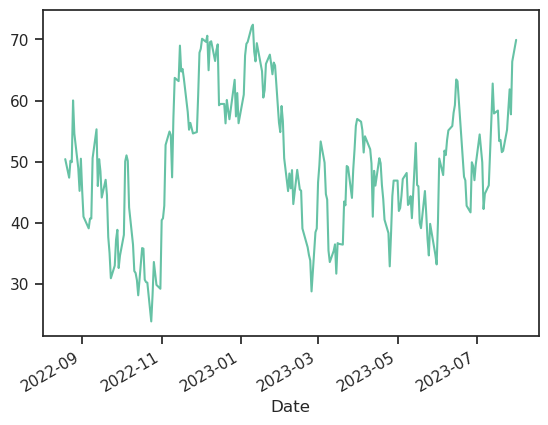

In [10]:
# Calculate RSI

funds['RSI'] = talib.RSI(funds['msauxclose'], timeperiod=14)

funds['RSI'].plot()

In [15]:
# get log returns of the fund

returns=funds[['msauxclose','miopxclose','mggpxclose','mfapxclose']].to_log_returns().dropna()

returns.head()

,msauxclose,miopxclose,mggpxclose,mfapxclose
Date,,,,
2022-08-02,-0.002139,-0.007497,0.013048,-0.017383
2022-08-03,0.017512,0.031804,0.035296,0.017862
2022-08-04,0.007860,0.023730,0.024370,0.020365
2022-08-05,0.003127,-0.011795,-0.005248,-0.015592
2022-08-08,-0.010460,0.003806,-0.001404,0.007590


In [16]:
# get correlation matrix

returns.corr().as_format('.2f')

,msauxclose,miopxclose,mggpxclose,mfapxclose
msauxclose,1.00,0.75,0.55,0.68
miopxclose,0.75,1.00,0.91,0.96
mggpxclose,0.55,0.91,1.00,0.82
mfapxclose,0.68,0.96,0.82,1.00


### Rebasing 

Rebasing of funds, in the context of financial analysis and investment, is a technique used to adjust the base value of a fund or investment index. It involves resetting the initial value of the fund or index to a specific reference point, usually a fixed number or a certain date, to facilitate meaningful comparisons over time. The primary purpose of rebasing is to eliminate the impact of historical changes, such as dividends, splits, or inflation, so that investors can focus on the relative performance and growth of the investment.

Initial Value Reset: When a fund or index is rebased, its historical value is adjusted so that it starts from a new base value. This base value is typically set to 100 or another round number for simplicity. This means that the index or fund starts at 100 and moves up or down from there.



<Axes: title={'center': 'Rebased funds'}, xlabel='Date', ylabel='Closing price'>

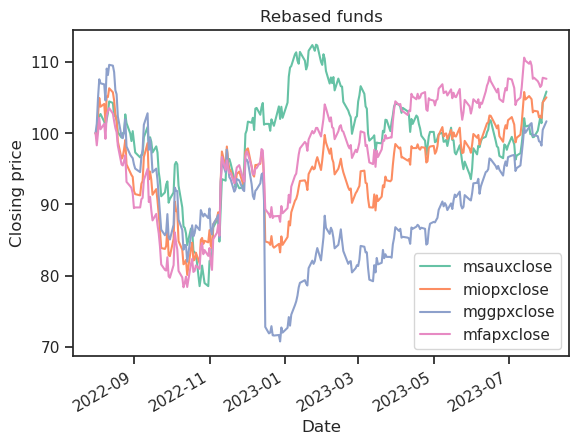

In [17]:
# rebasing the fund

funds[['msauxclose','miopxclose','mggpxclose','mfapxclose']].rebase().plot(ylabel='Closing price',title='Rebased funds')


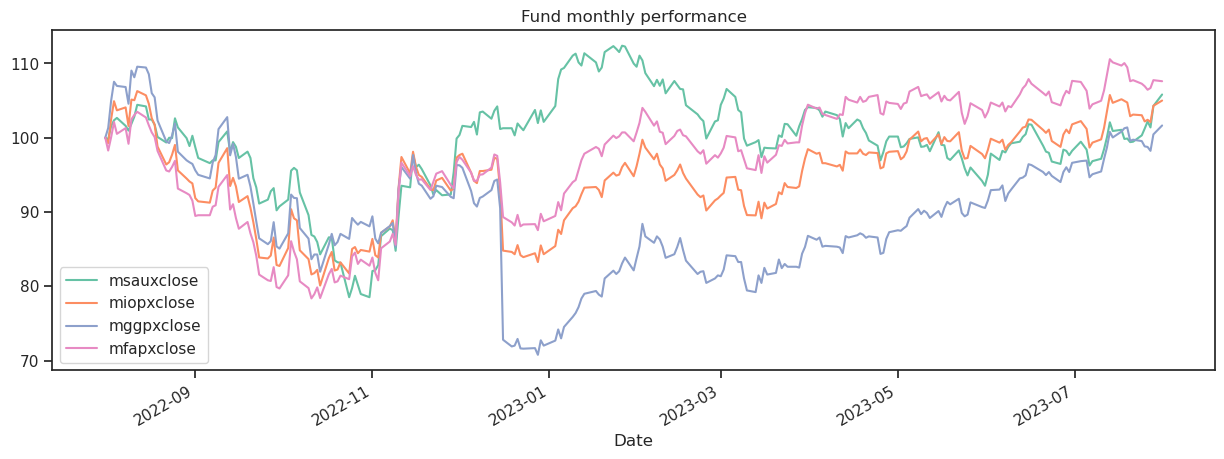

In [19]:
# Fund performance

funds = funds[['msauxclose','miopxclose','mggpxclose','mfapxclose']].dropna()

performance = funds.calc_stats()

performance.plot(title='Fund monthly performance')

plt.legend()


In [20]:
performance.display()

Stat                 msauxclose    miopxclose    mggpxclose    mfapxclose
-------------------  ------------  ------------  ------------  ------------
Start                2022-08-01    2022-08-01    2022-08-01    2022-08-01
End                  2023-07-31    2023-07-31    2023-07-31    2023-07-31
Risk-free rate       0.00%         0.00%         0.00%         0.00%

Total Return         5.82%         5.01%         1.65%         7.61%
Daily Sharpe         0.35          0.31          0.23          0.42
Daily Sortino        0.63          0.53          0.32          0.75
CAGR                 5.84%         5.03%         1.66%         7.64%
Max Drawdown         -24.81%       -24.64%       -35.41%       -24.28%
Calmar Ratio         0.24          0.20          0.05          0.31

MTD                  7.72%         3.15%         5.20%         -0.04%
3m                   5.65%         7.03%         16.47%        2.79%
6m                   -3.41%        9.18%         21.32%        6.84%
YTD       

The statistics shows that compared in performance MFAPX has the best performance in terms of total returns and CAGR. It also has a not the worst drawdown average of -5% and average 30 days of drawdown. Therefore it is better investment that the other funds compared here.
